# Modeling

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm

from sklearn.metrics import make_scorer
from sklearn.linear_model import LinearRegression
from catboost import CatBoostRegressor
from datetime import datetime, timedelta

import pickle

import copy
import os

import warnings

warnings.filterwarnings('ignore')

In [2]:
cwd = os.getcwd()

PATH_SALES_DF_TRAIN = cwd + '/data/raw/sales_df_train.csv'
PATH_TO_SAVE_ST_DF = cwd + '/data/preprocessing/preproc_st_df.csv'
PATH_TO_SAVE_PR_DF = cwd + '/data/preprocessing/preproc_pr_df.csv'
PATH_TO_SUMISSION_DF = cwd + '/data/raw/sales_submission.csv'

PATH_TO_SAVE_HOLIDAYS = cwd + '/data/holidays.csv'

PATH_TO_SAVE_TRAIN_DF_NO_OTLIERS = cwd + '/data/preprocessing/preproc_df_train_no.csv'
PATH_TO_SAVE_TRAIN_DF = cwd + '/data/preprocessing/preproc_df_train.csv'

PATH_TO_SAVE_TEST_DF = cwd + '/data/preprocessing/preproc_df_test.csv'
PATH_TO_SAVE_TEST_DF_NO_OTLIERS = cwd + '/data/preprocessing/preproc_df_test_no.csv'

PATH_TO_SAVE_SUMISSION_DF = cwd + '/data/submission/sales_submission.csv'

PATH_TO_SAVE_MODELS = cwd + '/models'


Создадим функцию для оценки качества, поскольку нужно будет оценивать качество как на широкой таблице, так и на узкой, то пропишем доп обработку входных значений.

In [3]:
def wape(y_true: np.array, y_pred: np.array):
    if type(y_true) == pd.DataFrame:
        y_true = y_true.values.reshape(-1)
    elif type(y_true) != pd.Series:
        y_true = y_true.reshape(-1)
        
    if type(y_pred) == pd.DataFrame:
        y_pred = y_pred.values.reshape(-1)
    elif type(y_pred) != pd.Series:
        y_pred = y_pred.reshape(-1)
    return np.sum(np.abs(y_true-y_pred))/np.sum(np.abs(y_true))

Поскольку нам нужно минимизировать наше значение, то преобразуем нашу функциюю в loss (для оптимизации в GridSearch)

In [4]:
wape_loss = make_scorer(wape, greater_is_better=False)

Так как нам нужно обучить разные модели на разных товарах, то будем создавать словарь с моделями, которые проверим на необработанных данных, которые модель не видела

## Создание baislain

Создадим наивную модель. Для начала откроем сырые данные

In [5]:
df_y_test = pd.read_csv(PATH_SALES_DF_TRAIN)[['pr_sku_id', 'st_id', 'pr_sales_in_units', 'date', 'pr_sales_type_id']]

Проведём аггрегацию по пересекающимся полям, что бы продукт для каждой даты встречался один раз (с разбиением на промо и без

In [6]:
df_y_test = (df_y_test.groupby(['pr_sku_id', 'st_id', 'pr_sales_in_units', 'date'])['pr_sales_type_id']
                      .agg('sum')
                      .reset_index(drop=False)
                      .sort_values('date'))
df_y_test['date'] = pd.to_datetime(df_y_test['date'])
df_y_test = df_y_test.sort_values('date')

Для того, чтобы можно было чисто протестировать потом модель отложим последние 28 дней.

In [7]:
last_date = df_y_test['date'].max()
first_date = last_date - timedelta(days=28)
valid_end_date = last_date - timedelta(days=14)

In [8]:
last_date, first_date, valid_end_date

(Timestamp('2023-07-18 00:00:00'),
 Timestamp('2023-06-20 00:00:00'),
 Timestamp('2023-07-04 00:00:00'))

Получим данные для даты идущей перед валидационным отрезком

In [9]:
df_in_date = df_y_test.loc[df_y_test['date']=='2023-06-19']

Последующие 14 дней будем предсказывать по последней известной цене

In [10]:
list_df = []
for d in range(0, 14):
    date = first_date + timedelta(days=d)
    df = df_in_date.copy(deep=True)
    df['date'] = date
    df = df.rename(columns={'pr_sales_in_units': 'target'})
    list_df.append(df)
    
predict_df = pd.concat(list_df, axis=0)

In [11]:
predict_df

,pr_sku_id,st_id,target,date,pr_sales_type_id
553228,a5dd747c3e76dcf7c846d5cda73ded24,42a0e188f5033bc65bf8d78622277c4e,1.0,2023-06-20,0
794660,ec64491cf0ea4b8a3cde5e351582631d,fa7cdfad1a5aaf8370ebeda47a1ff1c3,1.0,2023-06-20,0
141503,32cfba8a13694631a8418e4d246e55fa,16a5cdae362b8d27a1d8f8c7b78b4330,0.0,2023-06-20,0
835389,f8e67df2dd557f44074271107ab9781a,42a0e188f5033bc65bf8d78622277c4e,4.0,2023-06-20,1
401616,706b9e39dd3ca40669b5f5c74bfebeb8,f7e6c85504ce6e82442c770f7c8606f0,4.0,2023-06-20,0
...,...,...,...,...,...
46332,11e6eda3c45e0e17437074dad5842a08,fa7cdfad1a5aaf8370ebeda47a1ff1c3,0.0,2023-07-03,0
78798,1cec786e41a51f75b5701511f995218b,f7e6c85504ce6e82442c770f7c8606f0,1.0,2023-07-03,1
547696,a3dd40d8e9190be52a593ad39a3fd78e,1ecfb463472ec9115b10c292ef8bc986,12.0,2023-07-03,1
837173,f9913de6246f7b1d28d51261c268f0ae,42a0e188f5033bc65bf8d78622277c4e,2.0,2023-07-03,0


Напишем функцию для получения среза данных для валидации, и переименуем столбец с целевым признаком

In [12]:
def get_valid_data (df_y_test, first_date):
    df_valid_data = df_y_test.copy(deep=True)
    df_valid_data.index = pd.to_datetime(df_valid_data['date'])
    df_valid_data = df_valid_data.loc[first_date: first_date + timedelta(days=13)]
    df_valid_data = df_valid_data.rename(columns={'pr_sales_in_units': 'y_true'})
    df_valid_data = df_valid_data.reset_index(drop=True)
    return df_valid_data

In [13]:
df_valid_data = get_valid_data (df_y_test, first_date)

Соединим два датасета и заполним пропуки нулями

In [14]:
df_valid_data = df_valid_data.merge(predict_df, on=['date', 'pr_sku_id', 'st_id', 'pr_sales_type_id'], how='outer')
df_valid_data = df_valid_data.fillna(0)
df_valid_data

,pr_sku_id,st_id,y_true,date,pr_sales_type_id,target
0,6e5d274636cdf86dabee3f8658794d54,1ecfb463472ec9115b10c292ef8bc986,12.0,2023-06-20,0,0.0
1,42a303fc7a6b682be534d5a0e8d3a115,fa7cdfad1a5aaf8370ebeda47a1ff1c3,6.0,2023-06-20,0,3.0
2,775d43db5ba7c26ace5162e82aed780f,f7e6c85504ce6e82442c770f7c8606f0,3.0,2023-06-20,0,1.0
3,611f825b294117975c8d5c112cfb44ad,fa7cdfad1a5aaf8370ebeda47a1ff1c3,1.0,2023-06-20,0,2.0
4,543f17ebd9d464531d61fcdeaa36678f,c81e728d9d4c2f636f067f89cc14862c,0.0,2023-06-20,0,1.0
...,...,...,...,...,...,...
48729,50a87fe641d22f2f6563948e8d7bb1b2,16a5cdae362b8d27a1d8f8c7b78b4330,0.0,2023-07-03,0,2.0
48730,11e6eda3c45e0e17437074dad5842a08,fa7cdfad1a5aaf8370ebeda47a1ff1c3,0.0,2023-07-03,0,0.0
48731,1cec786e41a51f75b5701511f995218b,f7e6c85504ce6e82442c770f7c8606f0,0.0,2023-07-03,1,1.0
48732,a3dd40d8e9190be52a593ad39a3fd78e,1ecfb463472ec9115b10c292ef8bc986,0.0,2023-07-03,1,12.0


Посмотрим на метрику наивной модели

In [15]:
wape(df_valid_data['y_true'], df_valid_data['target'])

0.9059494719620778

Визуализируем полученный прогноз

In [16]:
def visualize_pred(df, name_plot_model, name_pred_column = 'target', name_true_column = 'y_true'):
    df = df.groupby('date')[['target', 'y_true']].agg('mean')
    plt.title(f'График прогноза и реальных значений (средние значения по дате) для модели {name_plot_model}')
    plt.plot(df[name_pred_column], label='prediction')
    plt.plot(df[name_true_column], label='test')
    plt.legend()
    plt.xticks(rotation=45)
    plt.show()

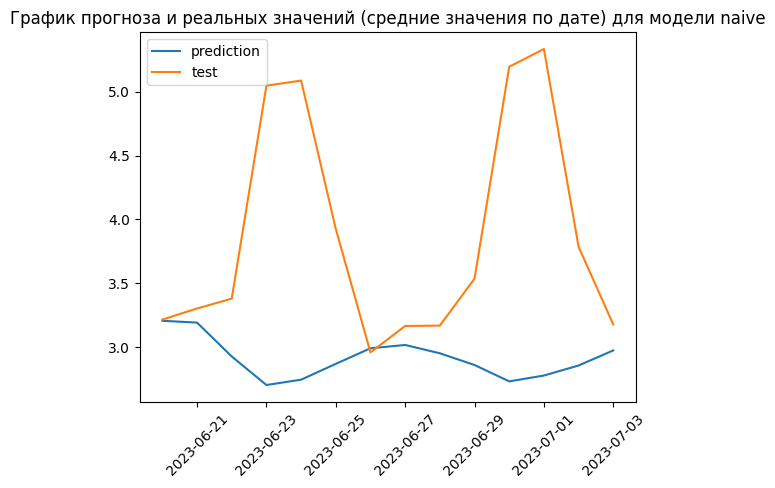

In [17]:
visualize_pred(df_valid_data, 'naive')

Это будет нашим безлайном, который мы попробуем побить

## Создание моделей

Поработаем с признаками, для этого для этого создадим функцию, которая будет открывать требуемый датасет и получать срезы.

In [18]:
def get_df(path, date, is_train=True):
    df = pd.read_csv(path, index_col=0)
    df.index = pd.to_datetime(df.index)
    df = df.sort_index()
    if is_train:
        df = df.loc[:(date - timedelta(days=1))]
    else:
        df = df.loc[date]
        target_list = df.columns[df.columns.str.contains('target', case=False)]
        df = df.drop(target_list, axis=1)
    return df

In [19]:
# поскольку модель должна быть обучена 14 дней назад, так как иначе не былотаргета
df_train = get_df(PATH_TO_SAVE_TRAIN_DF_NO_OTLIERS, first_date - timedelta(days=14)) 

Выберем все столбцы, которые содержат слово target, чтобы в дальнейшем выделить столбцы для обучения

Получим список признаков содержащих слово target, чтобы выделить отдельно признаки и цели обучения

In [20]:
target_list = df_train.columns[df_train.columns.str.contains('target', case=False)]

Напишем функцию, которая будет обучать модели для каждой группы с дефолтными параметрами.

In [21]:
def fit_models(df, model, target_list):
    dict_mod = {}
    list_mod = df['group_shop_cat'].unique()
    for i, name_mod in enumerate(list_mod):
        df_train_mod = df[df['group_shop_cat'] == name_mod].copy(deep=True)
        df_train_mod = df_train_mod.drop('group_shop_cat',axis=1)

        X_train = df_train_mod.drop(target_list, axis=1)
        y_train = df_train_mod[target_list] 
        
        new_model = copy.deepcopy(model)
        new_model.fit(X_train, y_train)
        dict_mod[name_mod] = new_model
    return dict_mod

In [22]:
model = LinearRegression()
dict_mod = fit_models(df_train, model, target_list)

Напишем функцию, которая будет делать предсказания на основе датасета с датой с которой нужно сделать предсказание на 14 дней вперёд в формате указанном в ТЗ.

In [23]:
def get_predict(df_test, 
                df_for_pred, 
                st_df, 
                pr_df, 
                dict_mod, 
                not_promo=False, 
                return_y_true=False, 
                only_st_sku=False):
    # получим последнюю дату в датасете
    last_date = df_test.index.max()
    list_models = df_test.loc[last_date, 'group_shop_cat'].unique()

    #создадим списко для названия столбцов предикта в соответствии с датами
    list_columns = []
    for i in range(14):
        list_columns.append(last_date + timedelta(days=i))

    # создадим список для предсказаний и пройдёмся по всем моделям
    list_predict = []
    for name_model in list_models: 
        df_test_for_pred = df_test[df_test['group_shop_cat'] == name_model].copy(deep=True)   
        if df_test_for_pred.shape[0] > 0:
            #Сохраним столбцы, чтобы в дальнейшем их можно было присоединить к датасету
            group_shop_cat = df_test_for_pred['group_shop_cat'].reset_index(drop=True)
            pr_sales_type = df_test_for_pred['pr_sales_type_id'].reset_index(drop=True)
            pr_pr_uom_id = df_test_for_pred['pr_uom_id'].reset_index(drop=True)
            
            # сделаем прогноз
            X_test = df_test_for_pred.drop(['group_shop_cat'],axis=1)
            model = dict_mod[name_model]            
            y_pred = model.predict(X_test)

            # получим широкий датасет, где для каждой строки будет столбец с прогнозом на конкретную дату на 14 дней вперёд
            predictions_data = pd.DataFrame(data=y_pred, columns=list_columns)
            predictions_data['group_shop_cat'] = group_shop_cat
            predictions_data['pr_sales_type_id'] = pr_sales_type
            predictions_data['pr_uom_id'] = pr_pr_uom_id

            # развернём получившийся датасет в узкую таблицу (поскольку именно в таком формате она нужна по заданию)
            predictions_data = predictions_data.melt(['group_shop_cat', 'pr_sales_type_id', 'pr_uom_id'], 
                                                     var_name='date', 
                                                     value_name='target')
            list_predict.append(predictions_data)

    # соединим прогнозы каждой из модели
    pred = pd.concat(list_predict)
    # получим пересечение всех товаров со всеми магазинами, добавим столбец с таким же названием какой был у моделей
    # и соединим их с нашим рогнозом
    st_pr_df = st_df.merge(pr_df, how='cross')
    st_pr_df['group_shop_cat'] = st_pr_df['group_shop'] + '_' + st_pr_df['group_cat']
    st_pr_df = st_pr_df.drop(['group_cat', 'group_shop'], axis=1)
    pr_data = pred.merge(st_pr_df, on='group_shop_cat', how='left')
    df_for_pred = df_for_pred.merge(pr_df[['pr_sku_id', 'pr_uom_id']], on = 'pr_sku_id', how='left')

    # приведём столбец с датой и прогнозного датасета и датасета с запросом к одному типу, чтобы не было проблем при их соединении
    pr_data['date'] = pd.to_datetime(pr_data['date'])
    df_for_pred['date'] = pd.to_datetime(df_for_pred['date'])

    # объединим прогнозный датасет и датасет с запросом на предсказание с учётом того нужно ли возвращать все столбцы
    if only_st_sku:
        pr_data = pr_data.merge(df_for_pred, on=['st_id', 'pr_sku_id', 'date'], how='right')                
    else:
        pr_data = pr_data.merge(df_for_pred, on=['st_id', 'pr_sku_id', 'date', 'pr_sales_type_id', 'pr_sku_id'], how='right')
    pr_data = pr_data.fillna(0)

    # обработаем возврат информации по промо
    if not_promo:
        pr_data = pr_data[pr_data['pr_sales_type_id'] == 0]
        return_list = ['st_id', 'pr_sku_id', 'date', 'target']
        if return_y_true and 'y_true' in pr_data.columns:
            return_list.append('y_true')
        pr_data = pr_data[return_list]
    # сгруппируем данные по столбцам и сагрегируем таргет как среднее
    # одинаковые записи могу твозник при пересечении разных множеств (например изменение типа продажи товара по штукам или на вес и т.д.) 
    pr_columns = list(pr_data.columns)
    pr_columns.remove('target')
    if not only_st_sku:
        pr_columns.remove('y_true')
        pr_data = pr_data.groupby(pr_columns)[['target', 'y_true']].agg('mean').reset_index(drop=False)
    else:
        pr_data = pr_data.groupby(pr_columns)[['target']].agg('mean').reset_index(drop=False)

    return pr_data

Получим датасетс с информацией на день начала периода валидации

In [24]:
df_valid_data = get_valid_data (df_y_test, first_date)

In [25]:
df_test = get_df(PATH_TO_SAVE_TRAIN_DF_NO_OTLIERS, first_date, is_train=False) 
st_df = pd.read_csv(PATH_TO_SAVE_ST_DF)
pr_df = pd.read_csv(PATH_TO_SAVE_PR_DF)

In [26]:
pred = get_predict(df_test, df_valid_data, st_df, pr_df, dict_mod)

Поскольку мы передовали не датафрейм для предсказаний, а дф для валидации, то можем сразу получить wape и построить график

In [27]:
wape(pred['y_true'], pred['target'])

0.7922711255655601

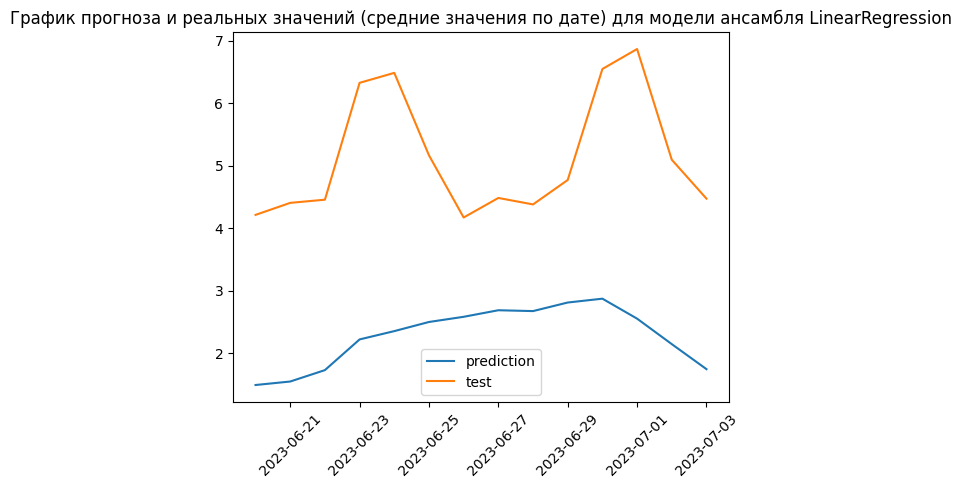

In [28]:
visualize_pred(pred, 'ансамбля LinearRegression')

Модель по качеству wape получилась немного лучше попробуем улучшить её.

## Оптимизация признаков

Попробуем улучшить качество нашей модели путем подбора оптимальных признаков для этого воспользуемся функциями разработанными на этапе предообработки данных.

In [29]:
def get_clear_df(df, var_for_na=0.01, var_for_null=0):
    dict_df = {}     
    df_date = pd.DataFrame(data=df['date'].copy(deep=True).unique(), columns=['date'])
    df_date = df_date.sort_values('date').reset_index(drop=True)
    df = df.copy(deep=True)
    df['all_st_pr'] =  df['st_id'] + '_' + df['pr_sku_id']
    for x in df['all_st_pr'].unique():
        new_df = df.loc[df['all_st_pr']==x].copy(deep=True)
        
        # оставим в датасете только значения с целевым признаком больше или равных 0
        new_df = new_df[new_df['pr_sales_in_units']>=0].reset_index(drop=True)
        if new_df.shape[0] > 0:
            #сделаем словарь для заполнения пропусков
            list_col = list(new_df.columns)
            list_col.remove('pr_sales_in_units')
            dict_for_fillna = {k: new_df.loc[0, k] for k in list_col}

            new_df = new_df.merge(df_date, on='date', how='outer')
            
            for k, v in dict_for_fillna.items():
                new_df[k] = new_df[k].fillna(v)

            new_df['pr_sales_in_units'] = new_df['pr_sales_in_units'].fillna(var_for_na)
            new_df[new_df['pr_sales_in_units']==0] = var_for_null
            new_df['date'] = pd.to_datetime(new_df['date'])
            new_df = new_df.sort_values('date')
            new_df = new_df.drop('all_st_pr', axis=1)
            dict_df[x] = new_df
    return pd.concat(dict_df.values(),axis=0).sort_values(['date','st_id', 'pr_sku_id'])

In [30]:
def get_group_and_agg(df, strareg_agg='mean'):
    #укажем столбцы для группировки и проведём аггрегацию данных
    group_column = ['st_id', 'group_cat', 'pr_sales_type_id', 'pr_uom_id']
        
    df = (df.groupby(['date', *group_column])['pr_sales_in_units']
                       .agg(strareg_agg)
                       .reset_index(drop=False)
                       .sort_values(['date', *group_column]))  
    df['group_column'] = df['st_id'].astype('str') + '_' + df['group_cat'].astype('str') + '_' + df['pr_sales_type_id'].astype('str')
    return df 

In [31]:
def get_date_and_weekday(df):
    #приведём дату в нужный формат, укажем новый индекс и день недели
    df['date'] = pd.to_datetime(df['date'])
    df.index = df['date']
    df['weekday'] = df['date'].dt.weekday 
    df = df.drop('date', axis=1)
    df['weekend'] = (df['weekday'] == 5) | (df['weekday'] == 6)
    for i in range(7):
        df[f'weekday_{i}'] = df['weekday']==i
         
    return df

In [32]:
def get_dict(df, group_column):
    dict_df = {}     
    for x in df[group_column].unique():
        new_df = df.loc[df[group_column]==x].copy(deep=True).reset_index(drop=True)
        dict_df[x] = new_df
    return dict_df

In [33]:
def processing_outliers(df, column, threshold):
    df['rolling_mean_30'] = (df[column]
                           .shift()
                           .rolling(30)
                           .mean())
    df.loc[df['rolling_mean_30']==0, 'rolling_mean_30'] = 0.001 #защита от деления на 0
    df['ratio'] = df[column].shift() / df['rolling_mean_30']
    df.loc[df['ratio'] > threshold, column] = df.loc[df['ratio'] > threshold, 'rolling_mean_30'] * threshold
    df = df.drop(['ratio', 'rolling_mean_30'], axis=1)
    return df

In [34]:
def get_mean_in_day(df, weekday_column, column, n_week):
    list_weekday_column = df[weekday_column].unique()
    for day in list_weekday_column: 
        new_name_mean = f'mean_in_weekday_{n_week}_week'  
        df.loc[(df[weekday_column]==day), new_name_mean] = (df[df[weekday_column]==day][column]
                                                           .shift()
                                                           .rolling(n_week)
                                                           .mean())
    df = df.drop(weekday_column, axis=1)     
    return df

In [35]:
def get_rolling(df, column, n_day_list):    
    for n_day in n_day_list:
        new_name_mean = f'rolling_mean_{n_day}'
        new_name_max = f'rolling_max_{n_day}'
        new_name_min = f'rolling_min_{n_day}'        
        new_name_max_min = f'rolling_max_min_{n_day}'
        new_name_ratio = f'rolling_ratio_{n_day}'     
        df[new_name_mean] = (df[column]
                               .shift()
                               .rolling(n_day)
                               .mean())
        df[new_name_max] = (df[column]
                               .shift()
                               .rolling(n_day)
                               .max())
        df[new_name_min] = (df[column]
                               .shift()
                               .rolling(n_day)
                               .min())
        df[new_name_max_min] = (df[new_name_max] + df[new_name_min]) / 2
        
        df.loc[df[new_name_mean]==0, new_name_mean] = 0.001 #защита от деления на 0
        df[new_name_ratio] = df[new_name_max_min] / df[new_name_mean]
        df
    return df

In [36]:
def get_lag(df, column, n_day_list):
    for n_day in n_day_list:
        new_name = f'lag_{n_day}'
        df[new_name] = (df[column].shift(n_day)) 
        
    df['mean_week_lag'] = df[['lag_5', 'lag_6', 'lag_7']].mean(axis=1)
    return df

In [37]:
def get_features_ny_e_h(df, list_holidays):
    #Добавим флаг нового года и пасхи
    df['new_year'] = df.index=='2023-01-01'
    df['easter'] = df.index=='2023-04-16'
    #
    df['week_after_new_year'] = (df.index > '2023-01-01') & (df.index <= '2023-01-08')
    df['week_after_easter'] = (df.index > '2023-04-16') & (df.index <= '2023-01-23')
    # Добавим флаг после нового года и пасхи
    df['week_befor_new_year'] = (df.index > '2022-12-24') & (df.index < '2023-01-01')
    df['week_befor_easter'] = (df.index > '2023-04-09') & (df.index <= '2023-04-16')

    #Обработаем список праздников
    df['holiday'] = df.index.isin(list_holidays)
    return df

In [38]:
def get_target_diapazon(df, column, n_day, is_train=True):
    df = df.copy(deep = True)
    df = df.rename(columns = {'pr_sales_in_units': 'target_0'})
    if is_train:
        for n_day in range(1, n_day):           
            new_name = f'target_{n_day}'
            df[new_name] = df['target_0'].shift(-n_day)
    return df

In [39]:
def get_features_for_ts(df, 
                        is_train = True, 
                        n_day_target = 14,
                        column = 'pr_sales_in_units',
                        strareg_agg='mean',
                        var_for_na = 0.01, 
                        var_for_null = 0,
                        weekday_column = 'weekday',
                        n_week_for_lag = 4,
                        n_day_rolling_list = [7, 14, 30],
                        n_day_lag_list = list(range(1,15)),
                        list_holidays = [],
                        drop_outliers = False, 
                        threshold = 1.7):
    df = df.copy(deep = True)
    df = get_clear_df(df, var_for_na, var_for_null)
    df = get_group_and_agg(df, strareg_agg) 
    new_dict = {}
    dict_df = get_dict(df, 'group_column')
    for x in dict_df:
        df = dict_df[x].copy(deep = True)         
        if drop_outliers:
            df = processing_outliers(df, column, threshold)
        df = get_date_and_weekday(df)  
        df = get_mean_in_day(df, weekday_column, column, n_week_for_lag)
        df = get_rolling(df, column, n_day_rolling_list)
        df = get_lag(df, column, n_day_lag_list)
        df = get_features_ny_e_h(df, list_holidays)
        df = get_target_diapazon(df, column, n_day_target, is_train=is_train)        
        new_dict[x] = df
        
    return pd.concat(new_dict.values(),axis=0).sort_values(['date','group_column'])

In [40]:
def combine_shops_sales(st_df, df_ts, is_train=True):
    #объединим получившиеся датасеты, перезададим индексы и удалим пропуски в отсутсвующих торговых центрах
    df = df_ts.merge(st_df, on ='st_id', how='left')
    df.index = df_ts.index
    df = df.dropna(subset='group_shop')
    # Создадим столбец с уникальным сочитанием группы магазина и группы категории товра 
    # удалим ненужные столбцы и пропуски в данных
    df['group_shop_cat'] = df['group_shop'] + '_' + df['group_cat']
    df = df.drop(['st_id', 'group_cat', 'group_column', 'group_shop'], axis=1)
    df = df.dropna()
    return df

In [41]:
def preproceccing_df(df, 
                     pr_df, 
                     st_df, 
                     is_train = True, 
                     n_day_target = 14,
                     column = 'pr_sales_in_units',
                     strareg_agg='mean',
                     var_for_na = 0.01, 
                     var_for_null = 0,
                     weekday_column = 'weekday',
                     n_week_for_lag = 4,
                     n_day_rolling_list = [7, 14, 30],
                     n_day_lag_list = list(range(1,15)),
                     list_holidays = [],
                     drop_outliers = False, 
                     threshold = 1.7):
    
    df = df[['st_id', 'pr_sales_type_id', 'pr_sku_id', 'date', 'pr_sales_in_units']]
    df = df.merge(pr_df, on ='pr_sku_id')
    df = get_features_for_ts(df, 
                             is_train = is_train, 
                             n_day_target = n_day_target,
                             column = column,
                             strareg_agg = strareg_agg,
                             var_for_na = var_for_na, 
                             var_for_null = var_for_null,
                             weekday_column = weekday_column,
                             n_week_for_lag = n_week_for_lag,
                             n_day_rolling_list = n_day_rolling_list,
                             n_day_lag_list = n_day_lag_list,
                             list_holidays = list_holidays,
                             drop_outliers = drop_outliers, 
                             threshold = threshold)
    
    df = combine_shops_sales(st_df, df, is_train)
    return df

In [42]:
sales_df_train = pd.read_csv(PATH_SALES_DF_TRAIN)
sales_df_train['date'] = pd.to_datetime(sales_df_train['date'])
sales_df_train = sales_df_train.sort_values('date')
pr_df = pd.read_csv(PATH_TO_SAVE_PR_DF)
st_df = pd.read_csv(PATH_TO_SAVE_ST_DF)

In [43]:
list_holidays = (pd.read_csv(PATH_TO_SAVE_HOLIDAYS)['holidays'].values)

---

Напишем функцию для перебора параметров и получения датасета со значениями метрики

In [44]:
def get_best_param(sales_df_train, pr_df, st_df, first_date, list_holidays, list_var):
    param_list = []
    score_list = []
    for dict_param in tqdm(list_var):    
        df_train = preproceccing_df(sales_df_train[sales_df_train['date'] < first_date].copy(deep=True), 
                                       pr_df, 
                                       st_df,                             
                                       list_holidays = list_holidays,  
                                       **dict_param)
        df_test = preproceccing_df(sales_df_train[sales_df_train['date'] > '2023-05-15'].copy(deep=True), 
                                   pr_df, 
                                   st_df,                              
                                   list_holidays = list_holidays,
                                   is_train=False,
                                   **dict_param)
        df_test = df_test.loc[first_date]
        target_list = df_train.columns[df_train.columns.str.contains('target', case=False)]
        model = LinearRegression()
        dict_mod = fit_models(df_train, model, target_list)
        
        if 'target_0' in df_test.columns:
            df_test = df_test.drop('target_0', axis=1)
        pred = get_predict(df_test, df_valid_data, st_df, pr_df, dict_mod)    

        param_list.append(dict_param)
        score_list.append(wape(pred['y_true'], pred['target'])) 

    df = pd.DataFrame({'param': param_list,
                         'score': score_list})
    return df.sort_values('score')

Подберём значение для занолнение пропусков в датасете. При этом сначала, будем подберать параметры без удаления выбросов, поскольку порог выбросов будет очень сильно зависить от того, как мы заполням пропуски. Это немного ухудшит прогноз при поборе признаков, но потом, всё нормализуется

In [45]:
list_var = [{'var_for_na': x} for x in [0, 0.001, 0.01, 0.1]]

In [46]:
%%time
df_best = get_best_param(sales_df_train, pr_df, st_df, first_date, list_holidays, list_var)
df_best

100%|███████████████████████████████████████████████████████████████████████████████████| 4/4 [23:07<00:00, 346.80s/it]

CPU times: total: 23min 1s
Wall time: 23min 7s


,param,score
0,{'var_for_na': 0},9.614305e-01
3,{'var_for_na': 0.1},4.727542e+06
2,{'var_for_na': 0.01},4.242527e+07
1,{'var_for_na': 0.001},5.433939e+08


Лучшее значение показало заполнение 0, однако, учитывая, что мы используем линейную модель, то заполнение нулями, может привести к тому, что какой-то из признаков не сработает, и на тестовой выборке качество значительно просядет. Поэтому будем заполнять вторым по качеству значением (0,01)

Получим словарь с параметрами, обуспечивающие лучшее качество

In [47]:
df_best_dict = df_best[df_best['score'] == df_best['score'].min()].reset_index(drop=True).loc[0, 'param']

Проверим каким значением стоит заменять ноль и стоит ли это делать.

In [48]:
list_var = [{'var_for_null': x} for x in [0, 0.001, 0.01, 0.1]]

Сформируем соответсвующи списко со словарями и снова проверим качество модели

In [49]:
for i in list_var:
    i.update(df_best_dict)

In [ ]:
%%time
df_best = get_best_param(sales_df_train, pr_df, st_df, first_date, list_holidays, list_var)
df_best

 25%|████████████████████▊                                                              | 1/4 [05:57<17:51, 357.15s/it]

In [ ]:
df_best_dict = df_best[df_best['score'] == df_best['score'].min()].reset_index(drop=True).loc[0, 'param']

Столь малые изменения в замене нуля, не влияют на финальное качество модели

Посмотрим как влияют пороги обрезки выбросов. В качестве порогов рассмотрим 1.4, 1.5, 1.7, 2

In [ ]:
list_var = [{'drop_outliers': True,'threshold': x} for x in [1.4, 1.5, 1.7, 2]]

In [ ]:
for i in list_var:
    i.update(df_best_dict)

In [ ]:
%%time
df_best = get_best_param(sales_df_train, pr_df, st_df, first_date, list_holidays, list_var)
df_best

Подберём функцию агрегации данных

In [ ]:
df_best_dict = df_best[df_best['score'] == df_best['score'].min()].reset_index(drop=True).loc[0, 'param']
list_var = [{'strareg_agg': x} for x in ['mean', 'median', 'sum']]
for i in list_var:    
    i.update(df_best_dict)

In [ ]:
%%time
df_best = get_best_param(sales_df_train, pr_df, st_df, first_date, list_holidays, list_var)
df_best

Подберём оптимальное количество недель за которые считается среднее по дням недели

In [ ]:
df_best_dict = df_best[df_best['score'] == df_best['score'].min()].reset_index(drop=True).loc[0, 'param']
list_var = [{'n_week_for_lag': x} for x in [2, 3, 4]]
for i in list_var:
    i.update(df_best_dict)

In [ ]:
%%time
df_best = get_best_param(sales_df_train, pr_df, st_df, first_date, list_holidays, list_var)
df_best

Посчитаем оптимальное количество лагов

In [ ]:
df_best_dict = df_best[df_best['score'] == df_best['score'].min()].reset_index(drop=True).loc[0, 'param']
list_var = [{'n_day_lag_list': x} for x in [list(range(1,8)), list(range(1,15)), list(range(1,21))]]
for i in list_var:
    i.update(df_best_dict)

In [ ]:
%%time
df_best = get_best_param(sales_df_train, pr_df, st_df, first_date, list_holidays, list_var)
df_best

In [ ]:
df_best_dict = df_best[df_best['score'] == df_best['score'].min()].loc[0, 'param']

Выведем список оптимальных параметров и получим датасеты с этими параметрами

In [ ]:
df_best_dict

In [ ]:
df_best_dict = {'n_day_lag_list': [1, 2, 3, 4, 5, 6, 7],
                 'n_week_for_lag': 2,
                 'strareg_agg': 'mean',
                 'drop_outliers': True,
                 'threshold': 1.4,
                 'var_for_null': 0.01,
                 'var_for_na': 0.01}

In [ ]:
df_train = preproceccing_df(sales_df_train[sales_df_train['date'] < first_date].copy(deep=True), 
                               pr_df, 
                               st_df,                             
                               list_holidays = list_holidays,  
                               **df_best_dict)
df_test = preproceccing_df(sales_df_train[sales_df_train['date'] > '2023-05-15'].copy(deep=True), 
                           pr_df, 
                           st_df,                              
                           list_holidays = list_holidays,
                           is_train=False,
                           **df_best_dict).loc[first_date]

Оптимальные параметры для признаков {'n_day_lag_list': [1, 2, 3, 4, 5, 6, 7],
 'n_week_for_lag': 2,
 'strareg_agg': 'mean',
 'drop_outliers': True,
 'threshold': 1.4,
 'var_for_null': 0.01,
 'var_for_na': 0.01}

Посмотрим на получившуюся метрику и на визуализацию.

In [ ]:
df_test_for_pred = df_test.loc[first_date]
target_list = df_train.columns[df_train.columns.str.contains('target', case=False)]
model = LinearRegression()
dict_mod = fit_models(df_train, model, target_list)
if 'target_0' in df_test_for_pred.columns:
    df_test_for_pred = df_test_for_pred.drop('target_0', axis=1)
pred = get_predict(df_test_for_pred, df_valid_data, st_df, pr_df, dict_mod)    

In [ ]:
wape(pred['y_true'], pred['target'])

Учитывая, что для прогноза по ТЗ от нас требуется только предсказывать товары без промо, посмотрим на такие товары (передав соответствующие параметры в функцию прогноза.

In [ ]:
df_test_for_pred = df_test.loc[first_date]
target_list = df_train.columns[df_train.columns.str.contains('target', case=False)]
model = LinearRegression()
dict_mod = fit_models(df_train, model, target_list)
if 'target_0' in df_test_for_pred.columns:
    df_test_for_pred = df_test_for_pred.drop('target_0', axis=1)
pred = get_predict(df_test_for_pred, df_valid_data, st_df, pr_df, dict_mod, True, True)    

In [ ]:
wape(pred['y_true'], pred['target'])

In [ ]:
visualize_pred(pred, 'ансамбль LinearRegression с оптимизированными признаками')

Качество немного улучшилось, теперь убедимся в качестве модели на тестовой выборке

In [ ]:
model = CatBoostRegressor(random_state=123,
                          loss_function = 'MultiRMSE',
                          eval_metric = 'MultiRMSE',
                          n_estimators = 700,
                          thread_count = -1,
                          verbose=False)

In [ ]:
df_test_for_pred = df_test.loc[first_date]
target_list = df_train.columns[df_train.columns.str.contains('target', case=False)]
dict_mod = fit_models(df_train, model, target_list)
if 'target_0' in df_test_for_pred.columns:
    df_test_for_pred = df_test_for_pred.drop('target_0', axis=1)
pred = get_predict(df_test_for_pred, df_valid_data, st_df, pr_df, dict_mod, True, True)      

In [ ]:
wape(pred['y_true'], pred['target'])

Проведём грубую подборку параметов для кэтбуста. Поскольку будем подбирать только количество выборщиков, то сделаем это просто в цикле

In [ ]:
%%time
for n in [250, 500, 750, 1000]:
    model = CatBoostRegressor(random_state=123,
                              loss_function = 'MultiRMSE',
                              eval_metric = 'MultiRMSE',
                              n_estimators = n,
                              thread_count = -1,
                              verbose=False)
    df_test_for_pred = df_test.loc[first_date]
    target_list = df_train.columns[df_train.columns.str.contains('target', case=False)]
    dict_mod = fit_models(df_train, model, target_list)
    if 'target_0' in df_test_for_pred.columns:
        df_test_for_pred = df_test_for_pred.drop('target_0', axis=1)
    pred = get_predict(df_test_for_pred, df_valid_data, st_df, pr_df, dict_mod, True, True)    
    w = wape(pred['y_true'], pred['target'])
    print(f'Количество выборщиков {n} wape {w}')

Лучшее качество показала модель с 250 выборщиками. Обучим эту модель и построим для неё график

In [ ]:
model = CatBoostRegressor(random_state=123,
                          loss_function = 'MultiRMSE',
                          eval_metric = 'MultiRMSE',
                          n_estimators = 250,
                          thread_count = -1,
                          verbose=False)

df_test_for_pred = df_test.loc[first_date]
target_list = df_train.columns[df_train.columns.str.contains('target', case=False)]
dict_mod = fit_models(df_train, model, target_list)
if 'target_0' in df_test_for_pred.columns:
    df_test_for_pred = df_test_for_pred.drop('target_0', axis=1)
pred = get_predict(df_test_for_pred, df_valid_data, st_df, pr_df, dict_mod, True, True)     
visualize_pred(pred, 'ансамбль CatBoostRegressor')

## Анализ влияния признаков

Для каждой из построенных моделей посмотрим, какие признаки оказывают большее влияние (входят в топ 15), а также посчитаем какие признаки чаще оказываются в топ 15 для всех моделей.

In [ ]:
def get_features_impotance(dict_mod, top):
    list_df = []
    for model in dict_mod.keys():
        df = pd.DataFrame({'feature_names': dict_mod[model].feature_names_,
                 'feature_importances': dict_mod[model].feature_importances_})
        df = df.sort_values('feature_importances', ascending=False)
        df['model_name'] = model
        list_df.append(df.head(top))
    return pd.concat(list_df, axis=0).reset_index(drop=True)

In [ ]:
df_features_impotance = get_features_impotance(dict_mod, 15)

Выведем список наиболее часто встречающихся признаков

In [ ]:
df_features_impotance['feature_names'].value_counts()

Как видно из полученных результатов, больше всего на метрику оказывают влияние

## Проверка на тестовой выборке

Сымитируем полную обррабоку датасета с сырыми данными, сразу отделим обучающий датасет от тестового, чтобы точно никаких утечек быть не могло.

Откроем датасеты

In [ ]:
sales_df_train = pd.read_csv(PATH_SALES_DF_TRAIN)
sales_df_train['date'] = pd.to_datetime(sales_df_train['date'])
sales_df_train = sales_df_train.sort_values('date')
pr_df = pd.read_csv(PATH_TO_SAVE_PR_DF)
st_df = pd.read_csv(PATH_TO_SAVE_ST_DF)

Выделим тренировочный набор и тестовый разделив их по последней дате валидации

In [ ]:
valid_end_date

In [ ]:
df_for_train = sales_df_train[sales_df_train['date'] <= valid_end_date]
df_for_pred = sales_df_train[sales_df_train['date'] <= valid_end_date]

In [ ]:
df_for_test = sales_df_train[sales_df_train['date'] > valid_end_date]
df_for_test = df_for_test.rename(columns={'pr_sales_in_units': 'y_true'})

Для предсказания добавим один день со смещением вперёд (именно с него начнётся весь расчёт, для ниго мы можем рассчитать все параметры, поскольку все признаки считались с лагом -1)

In [ ]:
df_next_day = df_for_pred.loc[df_for_pred['date']==valid_end_date]
df_next_day['pr_sales_in_units'] = 0
df_next_day['date'] = valid_end_date + timedelta(days=1)
df_next_day = df_next_day.reset_index(drop=True)
df_for_pred = df_for_pred.reset_index(drop=True)
df_for_pred.loc[len(df_for_pred.index)] = df_next_day.loc[0]

Задаим параметы, полученные выше

In [ ]:
df_best_dict = {'n_day_lag_list': [1, 2, 3, 4, 5, 6, 7],
                 'n_week_for_lag': 2,
                 'strareg_agg': 'mean',
                 'drop_outliers': True,
                 'threshold': 1.4,
                 'var_for_null': 0.01,
                 'var_for_na': 0.01}

Для рассчёта выборки для прогноза требуется 30 дней день лаг, поэтому данный датасет сможем ограничить, чтобы не предобрабатывать его целиком.

In [ ]:
df_train = preproceccing_df(df_for_train.copy(deep=True), 
                               pr_df, 
                               st_df,                             
                               list_holidays = list_holidays,  
                               **df_best_dict)
df_pred = preproceccing_df(df_for_pred[df_for_pred['date'] > valid_end_date - timedelta(days=30)].copy(deep=True), 
                           pr_df, 
                           st_df,                              
                           list_holidays = list_holidays,
                           is_train=False,
                           **df_best_dict).loc[valid_end_date + timedelta(days=1)]

Получим прогноз

In [ ]:
model = CatBoostRegressor(random_state=123,
                          loss_function = 'MultiRMSE',
                          eval_metric = 'MultiRMSE',
                          n_estimators = 250,
                          thread_count = -1,
                          verbose=False)

In [ ]:
target_list = df_train.columns[df_train.columns.str.contains('target', case=False)]
dict_mod = fit_models(df_train, model, target_list)
if 'target_0' in df_pred.columns:
    df_pred = df_pred.drop('target_0', axis=1)
pred = get_predict(df_pred, df_for_test, st_df, pr_df, dict_mod, True, True)     

In [ ]:
wape(pred['y_true'], pred['target'])

In [ ]:
visualize_pred(pred, 'ансамбль CatBoostRegressor на тесте')

Качество осталось на сопостовимом уровне. Теперь обучим модели на полном датасете и сохраним их

In [ ]:
df_train = preproceccing_df(sales_df_train.copy(deep=True), 
                               pr_df, 
                               st_df,                             
                               list_holidays = list_holidays,  
                               **df_best_dict)

In [ ]:
model = CatBoostRegressor(random_state=123,
                          loss_function = 'MultiRMSE',
                          eval_metric = 'MultiRMSE',
                          n_estimators = 250,
                          thread_count = -1,
                          verbose=False)
target_list = df_train.columns[df_train.columns.str.contains('target', case=False)]
dict_mod = fit_models(df_train, model, target_list)

Сохраним получившиеся модели

In [ ]:
for k in dict_mod.keys():
    path_save = f'{PATH_TO_SAVE_MODELS}/{k}.pkl'
    with open(path_save, "wb") as f:
        pickle.dump(dict_mod[k], f)

## Прогнозирование спроса на сбмите

In [ ]:
sales_df_train = pd.read_csv(PATH_SALES_DF_TRAIN)
pr_df = pd.read_csv(PATH_TO_SAVE_PR_DF)
st_df = pd.read_csv(PATH_TO_SAVE_ST_DF)
submissions_df = pd.read_csv(PATH_TO_SUMISSION_DF)

Создадим функцию, которая будет получать датасеты, производить с ними необходимую предообработку и делать прогноз.

In [ ]:
def prediction_submitions(sales_df_train, pr_df, st_df, submissions_df, dict_mod):
    sales_df_train['date'] = pd.to_datetime(sales_df_train['date'])
    sales_df_train = sales_df_train.sort_values('date')
    submissions_df['date'] = pd.to_datetime(submissions_df['date'])
    submissions_df = submissions_df.drop('target', axis=1)
           
    df_for_pred = sales_df_train.copy(deep=True)
    
    #добавление в датасет следующей даты(для прогноза начиная с завтрашнего дня)
    last_date = sales_df_train['date'].max() 
    df_next_day = df_for_pred.loc[df_for_pred['date']==last_date]
    df_next_day['pr_sales_in_units'] = 0
    df_next_day['date'] = last_date + timedelta(days=1)
    df_next_day = df_next_day.reset_index(drop=True)
    df_for_pred = df_for_pred.reset_index(drop=True)
    df_for_pred.loc[len(df_for_pred.index)] = df_next_day.loc[0]
    
    # параметры для признаков
    df_best_dict = {'n_day_lag_list': [1, 2, 3, 4, 5, 6, 7],
                     'n_week_for_lag': 2,
                     'strareg_agg': 'mean',
                     'drop_outliers': True,
                     'threshold': 1.4,
                     'var_for_null': 0.01,
                     'var_for_na': 0.01}
    
    #проводим препроцессинг только для данных, за 30 дней назад
    df_pred = preproceccing_df(df_for_pred[df_for_pred['date'] > last_date - timedelta(days=30)].copy(deep=True), 
                               pr_df, 
                               st_df,                              
                               list_holidays = list_holidays,
                               is_train=False,
                               **df_best_dict).loc[last_date + timedelta(days=1)]
    
    target_list = df_train.columns[df_train.columns.str.contains('target', case=False)]
    if 'target_0' in df_pred.columns:
        df_pred = df_pred.drop('target_0', axis=1)
    pred = get_predict(df_pred, 
                       submissions_df, 
                       st_df, 
                       pr_df, 
                       dict_mod, 
                       not_promo=True, 
                       only_st_sku=True)   
    return pred

In [ ]:
submissions = prediction_submitions(sales_df_train, pr_df, st_df, submitions_df, dict_mod)

In [ ]:
submissions.to_csv(PATH_TO_SAVE_SUMISSION_DF,index=False)

## Общие выводы

В данном разделе была проведена работа по созданию модели машинного обучения и оценки её качества, в частности:
1. Создан baislain в виде наивной модели, которая прогнозирует спрос на уровне последнего известного проса
2. Разработан ансамбль моделей, каждый из которых прогназирует спрос для своего сегмента (сочетание категории товаров - группа магазинов). Данный алгоритм показал более высокий уровень чем baislain.
3. Написаны функции как для тренировки моделей, так и для получения предсказаний.
4. Оптимизированы признаки путём подбора наиболее эффективных значений.
5. Всё это позволило получить wape на валидационной и отложеной выборке меньше 0,8.

### Что ещё нужно сделать

В данной работе необходимо доделать (то на что не хватило времени):
1. Проработать группировку сочетания категории товаров - группа магазинов, вероятно можно улучшить каечство прогноза оптимизировав группировку (при любой группировке всегда будет предел качества, в который уткнётся модель). Следовательно нужно опять проработать EDA.
2. Поэкспериментировать с Catboostom, возможно он сможет дать лучшее качество модели.
3. Сделать предварительную генерацию признаков при помощи Propheta.
4. Провести подбор гиперпараметров на кроссвалидации (оптимально, если бы были данные за предыдущие года, чтобы модель научилась предсказывать годовую сезонность).